<img src="https://i1.wp.com/sublibanderas.com/wp-content/uploads/2021/04/kueski-pay-PNG.png?fit=455%2C130&ssl=1" align="center" width="400"/>

<div class="alert alert-block alert-warning">
    
## In this notebook we solve a Kaggle challenge for Kueski, focusing on feature engineering
    
</div>

<hr style="border:2px solid gray"> </hr>

# Import libraries

In [1]:
# Import libraries
import pandas as pd
import os
import datetime
import re
import time
import joblib
import sklearn
from sklearn.model_selection import GroupKFold

# Liberías para el tratamiento de los datos
import feature_engine
from feature_engine.imputation import AddMissingIndicator, CategoricalImputer, MeanMedianImputer, ArbitraryNumberImputer
from feature_engine.encoding import RareLabelEncoder
from feature_engine.outliers import Winsorizer
from feature_engine.selection import DropConstantFeatures, DropCorrelatedFeatures, SmartCorrelatedSelection
import category_encoders as ce
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.utils.validation import check_is_fitted
from utils import FeatureSelector, find_numerical_vars, BaseImputer, LinearModelImputer

# Librerías para modelado
import lightgbm as lgb
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from imblearn.pipeline import Pipeline
from copy import deepcopy
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import roc_auc_score, mean_squared_error, mean_absolute_error
from math import sqrt
import skopt
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize, forest_minimize, dump
# import joblib
from tqdm.notebook import tqdm

# Liberías para análisis del modelo
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
import shap


In [78]:
import matplotlib

In [79]:
print(matplotlib.__version__)

3.1.3


In [2]:
# We take the time of start of the execution
start_time = time.time()

In [3]:
#Seteamos para que no utilice notacion cientifica
pd.options.display.float_format = '{:.9f}'.format
#Seteo para que el máximo de columnas que muestra al levantar una base sean 500
pd.set_option('display.max_columns',500)
#Estos códigos hacen que la visualización de la consola abarque toda la pantalla (sin los recortes a los costados). Tambien hacen que al mostrar dataframes podamos ver todas las columnas que tiene.
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


# Codigo para poder imprimir multiples outputs en una misma línea
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Load input datasets

## 1. Main table

In [4]:
# Load rating data (first 100k rows) --> BECAUSE THIS IS A CHALLENGE! IT'S ONLY A DEMO OF MY WORK 
df = pd.read_csv('model_input/main_table.csv', sep=';', index_col=None, nrows=100000) 
# We add how old was the movie when the rating took place 
df['movie_recency'] = df['date'].str[:4].astype(int) - df['movie_year'].astype(float)
df['timestamp_year']=df['date'].str[:4].astype(int)
df.head()

,userId,movieId,rating,timestamp,date,target,title,movie_year,genre_film-noir,genre_documentary,genre_war,genre_horror,genre_thriller,genre_crime,genre_animation,genre_(no genres listed),genre_comedy,genre_musical,genre_romance,genre_sci-fi,genre_adventure,genre_action,genre_fantasy,genre_mystery,genre_imax,genre_western,genre_drama,genre_children,top_1_tagId,top_2_tagId,top_3_tagId,top_4_tagId,top_5_tagId,tag_original,tag_mentor,tag_great ending,tag_dialogue,tag_good soundtrack,tag_comedy,tag_action,tag_tense,tag_relationships,tag_horror,imdb_avg_rating,imdb_qnt_votes,movie_recency,timestamp_year
0,1,2,3.500000000,2005-04-02 23:53:47,2005-04-02,0,Jumanji (1995),1995.000000000,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,adventure,jungle,children,kids,special effects,0.719000000,0.610000000,0.429500000,0.372750000,0.246250000,0.540250000,0.646000000,0.120500000,0.101250000,0.064000000,6.000000000,240.000000000,10.000000000,2005
1,1,29,3.500000000,2005-04-02 23:31:16,2005-04-02,0,"City of Lost Children, The (Cité des enfants p...",1995.000000000,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0,0,1,0,dark fantasy,visually stunning,visual,surreal,imagination,0.884500000,0.472000000,0.732750000,0.659500000,0.738500000,0.057500000,0.091500000,0.138500000,0.154250000,0.024000000,6.000000000,3151.000000000,10.000000000,2005
2,1,32,3.500000000,2005-04-02 23:33:39,2005-04-02,0,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),1995.000000000,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,future,time loop,time travel,science fiction,sci fi,0.953750000,0.607250000,0.952000000,0.590500000,0.651750000,0.070000000,0.162000000,0.276250000,0.116000000,0.025250000,5.100000000,391.000000000,10.000000000,2005
3,1,47,3.500000000,2005-04-02 23:32:07,2005-04-02,0,Seven (a.k.a. Se7en) (1995),1995.000000000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,serial killer,detective,police investigation,powerful ending,dark,0.873500000,0.700250000,0.968750000,0.691750000,0.744250000,0.087250000,0.361250000,0.893000000,0.173250000,0.379500000,3.700000000,33.000000000,10.000000000,2005
4,1,50,3.500000000,2005-04-02 23:29:40,2005-04-02,0,"Usual Suspects, The (1995)",1995.000000000,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,oscar (best supporting actor),surprise ending,plot twist,twists & turns,twist ending,0.900250000,0.733000000,0.988500000,0.827250000,0.838750000,0.457500000,0.725250000,0.775500000,0.198750000,0.028750000,4.200000000,33.000000000,10.000000000,2005


### Features based on past user behavior:
*Big question: Is it better to watch some time behind? Or an amount of movies? We'll go for the later*
- How many movies does the user has rated?
- Average rate of the user --> Past 20 movies
- Average rate of the user --> Past 5 movies
- Amount of highs
- Rate of highs
- Trend of rating (past 20movies vs past 5movies)
- Years from the first rated movie 

We could add: 
- Average of how old were the movies they liked (target=1)
- Average of how old were the movies they rated
- Every metric but for each genre (if we have enough data)
- How many tags did the user applied to movies
- Most used tag applied for user

In [5]:
df['ub_mean_past_20_rates']=df.groupby('userId')['rating'].rolling(window=20, min_periods=1).mean().shift(1).reset_index()['rating'].values
df['ub_mean_past_5_rates']=df.groupby('userId')['rating'].rolling(window=5, min_periods=1).mean().shift(1).reset_index()['rating'].values
df['ub_qnt_highs']=df.groupby('userId')['target'].rolling(window=10000, min_periods=1).sum().shift(1).reset_index()['target'].values
df['ub_high_pct']=df.groupby('userId')['target'].rolling(window=10000, min_periods=1).mean().shift(1).reset_index()['target'].values
df['ub_qnt_rated']=df.groupby('userId')['rating'].rolling(window=10000, min_periods=1).count().shift(1).reset_index()['rating'].values
df['ub_trend_rating']= (df['ub_mean_past_5_rates'] / df['ub_mean_past_20_rates'])-1
df['ub_year_1st_rated'] = df.groupby('userId')['timestamp_year'].rolling(window=10000, min_periods=1).min().shift(1).reset_index()['timestamp_year'].values

In [6]:
# We drop the already used columns
df.drop(columns=['rating','title','movieId','timestamp_year'],inplace=True)

In [7]:
df.set_index('userId',inplace=True)

## Split Train, Test, and Out of Time sample: 
* Without containing the same users between train and test (to check how well the model generalizes)
* For the out of time sample we'll take the last year (to check how well does the model holds it's performance)

### First, we take out the OOT sample

In [8]:
max_year = df['date'].str[:4].max()
df_oot = df[df['date'].str[:4]==max_year]
df_noot = df[df['date'].str[:4]!=max_year]

# we drop date cols 
df_oot.drop(columns=['date','timestamp'],inplace=True)
df_noot.drop(columns=['date','timestamp'],inplace=True)

df_oot.head(3)

C:\Users\ruizf\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,target,movie_year,genre_film-noir,genre_documentary,genre_war,genre_horror,genre_thriller,genre_crime,genre_animation,genre_(no genres listed),genre_comedy,genre_musical,genre_romance,genre_sci-fi,genre_adventure,genre_action,genre_fantasy,genre_mystery,genre_imax,genre_western,genre_drama,genre_children,top_1_tagId,top_2_tagId,top_3_tagId,top_4_tagId,top_5_tagId,tag_original,tag_mentor,tag_great ending,tag_dialogue,tag_good soundtrack,tag_comedy,tag_action,tag_tense,tag_relationships,tag_horror,imdb_avg_rating,imdb_qnt_votes,movie_recency,ub_mean_past_20_rates,ub_mean_past_5_rates,ub_qnt_highs,ub_high_pct,ub_qnt_rated,ub_trend_rating,ub_year_1st_rated
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
31,0,1995.000000000,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,1,toys,computer animation,pixar animation,kids and family,animation,0.879250000,0.649250000,0.631500000,0.637500000,0.733750000,0.618000000,0.670500000,0.333500000,0.116500000,0.047250000,5.700000000,1847.000000000,20.000000000,3.075000000,2.800000000,6.000000000,0.193548387,31.000000000,-0.089430894,2008.000000000
31,1,1995.000000000,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,historical,oscar (best picture),history,oscar (best directing),courage,0.810000000,0.826250000,0.820500000,0.652000000,0.633250000,0.238000000,0.911250000,0.649000000,0.111000000,0.094500000,4.400000000,505.000000000,20.000000000,3.000000000,3.000000000,0.000000000,0.000000000,1.000000000,0.000000000,2015.000000000
31,1,1977.000000000,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,space opera,scifi,sci fi,trilogy,good versus evil,0.941750000,0.892750000,0.889250000,0.866500000,0.570250000,0.389750000,0.908000000,0.468000000,0.077250000,0.088250000,NaN,NaN,38.000000000,4.000000000,4.000000000,1.000000000,0.500000000,2.000000000,0.000000000,2015.000000000


### Then we split the rest (df not oot):
* Train sample --> 50% of the remaining data 
* Dev sample --> 25% of the remaining data (used to validate each iteration)
* Val sample --> 25% of the remaining data (used only to validate the final model)

In [9]:
# We define an useful function to split the dataset without overlapping users
def split_nonoverlapping_idx(data, target_col='target'):
    # Definimos X e Y
    X = data.drop(columns=target_col)
    y = data[[target_col]]
    # Y la variable por la cual armaremos los grupos
    groups = data.index.values
    n_splits=2
    group_kfold = GroupKFold(n_splits=n_splits)
    group_kfold.get_n_splits(X, y, groups)
    
    # tomaremos la ultima combinacion
    list_train_idx=[]
    list_test_idx=[]
    iterator = 0
    for train_index, test_index in group_kfold.split(X, y, groups):
        iterator+=1
        if iterator==n_splits:
            list_train_idx.append(train_index)
            list_test_idx.append(test_index)

    # En base a los indexes separados, armamos los dataframes de train y test
    X_train_aux, X_test_aux = X.iloc[list_train_idx[0]], X.iloc[list_test_idx[0]]
    y_train_aux, y_test_aux = y.iloc[list_train_idx[0]], y.iloc[list_test_idx[0]]
    # devolvemos los resultados

    return X_train_aux, y_train_aux, X_test_aux, y_test_aux

In [10]:
# First we split the data to get the TRAIN sample
X_train, y_train, X_test_v1, y_test_v1 = split_nonoverlapping_idx(df_noot)
# Use the "Test" part to build a df and divide it again
df_test = X_test_v1
df_test['target'] = y_test_v1.values
# Split TEST into DEV and VAL 
X_dev, y_dev, X_val, y_val = split_nonoverlapping_idx(df_test)

# Feature engineering and Preprocessing

- If the user has plenty past behaviour information --> OK
- If the user has none past behaviour information --> we compute NaN value
- If the user has some past behaviour --> ???? --> **Credibility metric**

### The main difference for the following features:
- We'll use OTHER USERS behaviour to build features for one user

### Preprocessing (Pipeline)

## Pipeline preprocesamiento

### Categorical Treatment:
* Variables Categóricas:
    1. Método para imputar missings categóricos (utilizado: se reemplazarán missings con la palabra "missing")
    2. Método para quitar niveles muy poco frecuentes (utilizado: si aparece en menos del 2% de registros se imputa como "Rare")
    3. Método para convertir en numérica las variables categóricas (utilizado: genera dummies/flags para cada valor de cada variable)

### Numerical Treatment
* Variables Numéricas:
    1. Método para imputación de missings en variables numéricas (utilizado: imputaremos con el valor medio de la variable, y a la vez colocaremos un flag de missing)
    2. Método para Capping/Flooring en variables numéricas

### General Treatment
* Aplicable tanto a variables numéricas como categóricas:
    1. Método para quitar variables (utilizado: quita variables que tengan el mismo valor en el 99.5% de los registros)
    2. Método de resampling, si fuera necesario (según datos y el target a predecir luego)

In [11]:
# Tomamos una lista con los atributos del dataframe X. Será útil para el pipel
featnames=list(X_train.columns)

# Creamos pipeline de preprocesamiento
pipe = Pipeline([
    # Selecciona todas las columnas disponibles en el dataframe de train
    ('selector', FeatureSelector(columns=featnames))
    
    # Categorical Treatment
    ,('categ_imputer', CategoricalImputer(imputation_method='missing') ) # Coloca texto "missing" donde hay NaNs en variables categóricas
    ,('categ_rare_encoder', RareLabelEncoder(tol=0.1, n_categories=1) ) # Método para quitar niveles muy poco frecuentes (niveles = valores de variables categóricas)
    ,('categ_encoder', ce.one_hot.OneHotEncoder(use_cat_names=True)) # Método para convertir categóricas a numéricas. Genera 1 dummy por cada nivel de cada variable
    
        
#     ,('pre_outlier_removal', Winsorizer(capping_method='quantiles', fold=0.01, missing_values='ignore')) # removemos outliers en los percentiles 5 y 95 (aquí ignoramos missings)
    
    # Numerical Treatment
    ,('numerical_missing_indicator', AddMissingIndicator(missing_only=True) ) # Coloca flag donde hay missings en las variables numéricas
    ,('numerical_imputer', ArbitraryNumberImputer(arbitrary_number=0) ) # Reemplaza missings por 0 (parece una muy mala opcion!! aunque no es tan mala si usamos Decision Trees, y además luego lo pondremos a prueba)
    
    # General Treatment
    ,('outlier_removal', Winsorizer(capping_method='quantiles', fold=0.02, missing_values='raise')) # removemos outliers en los percentiles 5 y 95
    ,('drop_nzv', DropConstantFeatures(tol=0.95)) # quita variables que tengan el mismo valor en el 90% de los registros
    ,('correlated_treatment', DropCorrelatedFeatures(method='pearson', threshold=0.8)) # Quita variables que tengan una correlación mayor a 0.8 (dropea el primer correlacionado que encuentra)
    ,('resampling', 'passthrough') # colocamos espacio para método de resampling, si fuera necesario (útil para problemas de clasificacion con clases desbalanceadas)
    
    # Nothing
    ,('nada','passthrough') # Para que el resampling no quede último ingresamos un step inútil
])

In [12]:
# Guardamos una copia del pipeline de procesamiento antes de fittearlo
pipe_clean = deepcopy(pipe)

### Fit Pipeline

In [13]:
%%time 
# Fitteamos el pipeline a los datos X e Y que tenemos en train (es decir, la clase ya sabrá que pasos seguir para imputar los missings, pero aún no lo ejecutará)
pipe_fitted = pipe.fit(X_train, y_train)

C:\Users\ruizf\AppData\Roaming\Python\Python37\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Wall time: 1.16 s


### Transform train data

In [14]:
# Aquí sí se ejecutan esos pasos, y se transforma (se preprocesa) el dataframe de entrada (nótese: para transformar los datos solo requiere X, porque ya "aprendió" la relación entre las X y las Y de train)
X_train_prep = pipe_fitted.transform(X_train)

# # Y aplicamos el resampleo si lo hubiera (de nuevo, en este caso no utilizaremos, tiene más sentido para clasificación con clases desbalanceadas)
# if pipe_fitted['resampling']=='passthrough':
#     # este sería el caso donde no se utiliza resampling
#     X_train_prepnres, y_train_prepnres = X_train_prep.copy(), y_train.copy()
# else:
#     # se aplica resapmling
#     X_train_prepnres , y_train_prepnres = pipe_fitted['resampling'].fit_resample(X_train_prep, y_train)

# Lo mismo para los datos de validación
X_dev_prep = pipe_fitted.transform(X_dev)

# Vemos si las dimensiones del dataframe cambiaron (deberían haber cambiado)
X_train.shape
X_train_prep.shape

X_dev.shape
X_dev_prep.shape

(49209, 46)

(49209, 30)

(24624, 46)

(24624, 30)

### Model

In [16]:
# define the model
model = lgb.LGBMClassifier()

In [17]:
# Lo fitteamos a la data de train
model.fit(X_train_prep, y_train)

C:\Users\ruizf\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LGBMClassifier()

In [18]:
# Definimos aquellos parámetros que queremos colocar, pero que queremos NO mover luego
FIXED_PARAMS = {         
                'random_state': 0,  
                'n_estimators':200,
                'objective':'binary',
                'boosting_type':'gbdt'
                     }

In [19]:
from skopt.space import Real, Integer, Categorical
cant_columnas = X_train_prep.shape[1]
space= [          
             Integer(2, 50, name='max_depth') # maxima profundidad de cada árbol (aquí sí es mejor que sean profundos, porque no se concatenan, son independientes)
            ,Real(0.3, 0.85, name='subsample') # porcentaje de filas que puede usar cada árbol
            ,Integer(round(cant_columnas*0.3), round(cant_columnas*1), name='max_features') # máxima cantidad de atributos (columnas) que puede usar cada árbol
            ,Real(0.001, 1, name='learning_rate') # tasa de aorebduzahe arbol a arbol
    
            ,Integer(round(len(X_train)*0.01), round(len(X_train)*0.1), name='min_child_samples') # mínima cantidad de registros para abrir una hoja
    
            ,Real(100, 1000,'log-uniform', name='reg_alpha') # L1 regularization
            ,Real(100, 1000,'log-uniform', name='reg_lambda') # L2 regularization
            
            ]
# listamos los nombres de los parámetros cuyo espacio de búsqueda acabamos de definir
param_names = ['max_depth','subsample','max_features','learning_rate','min_child_samples','reg_alpha','reg_lambda']

In [20]:
# Define a function to optimize metrics
def eval_metrics(y_true, y_pred):
    # KS
#     ks = ks_score(y_true, y_pred)
    # AUC
    auc = roc_auc_score(y_true, y_pred)
#     return[('ks',ks,True),('auc',auc,True)]
    return[('auc',auc,True)]

In [21]:
# Metric to optimize
LOSS_METRIC='auc'

In [22]:
results=[]

In [23]:
@use_named_args(space)
def objective(**params):
    """HP Search objective function"""
    #set params
    model.set_params(**FIXED_PARAMS)
    model.set_params(**params)
    # train
    model_fitted = model.fit(X_train_prep, y_train, 
                             eval_set=[(X_dev_prep, y_dev), (X_train_prep, y_train)],
                            eval_metric=eval_metrics,
                            early_stopping_rounds=50,
                            verbose=100)
    # get training results
    results_dict = model_fitted.get_params()
    results_dict['n_estimators'] = model_fitted.best_iteration_
    scores_train={f'{k}_train': v for k,v in model_fitted.best_score_['training'].items()}
    
    scores_dev={f'{k}_dev': v for k,v in model_fitted.best_score_['valid_0'].items()}
    
    results_dict.update(scores_train)
    results_dict.update(scores_dev)
    
    # append result to results list
    results.append(results_dict)
    # minus validation score
    loss = - model_fitted.best_score_['valid_0'][LOSS_METRIC]
    return loss

In [24]:
# Armamos una calse con tqdm para poder ver el progreso de la búsqueda
class tqdm_skopt(object):
    def __init__(self, **kwargs):
        self._bar = tqdm(**kwargs)
    def __call__(self, res):
        self._bar.update()
        
# Cantidad de iteraciones para la búsqueda (utilizar muchas, aqui usamos 50 solo por probar)
n_calls = 50

# Búsqueda
res = gp_minimize(
                    objective
                    ,space
                    ,n_calls = n_calls
                    ,n_initial_points = int(round(n_calls*0.2)) # Cantidad de iteraciones iniciales random (20% es significativo, pero dando mucho espacio para que el algoritmo optimice)
                    ,n_jobs=1
                    ,random_state = 0
                    ,verbose=1
                    ,callback=[tqdm_skopt(total=n_calls, desc="Gaussian Process")]
                    )

Gaussian Process:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration No: 1 started. Evaluating function at random point.


C:\Users\ruizf\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	training's binary_logloss: 0.586022	training's auc: 0.75651	valid_0's binary_logloss: 0.597848	valid_0's auc: 0.743126
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 3.3534
Function value obtained: -0.7431
Current minimum: -0.7431
Iteration No: 2 started. Evaluating function at random point.


C:\Users\ruizf\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	training's binary_logloss: 0.584877	training's auc: 0.758094	valid_0's binary_logloss: 0.596187	valid_0's auc: 0.745342
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 3.7360
Function value obtained: -0.7453
Current minimum: -0.7453
Iteration No: 3 started. Evaluating function at random point.


C:\Users\ruizf\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	training's binary_logloss: 0.601613	training's auc: 0.742585	valid_0's binary_logloss: 0.607698	valid_0's auc: 0.73435
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 2.7169
Function value obtained: -0.7343
Current minimum: -0.7453
Iteration No: 4 started. Evaluating function at random point.


C:\Users\ruizf\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	training's binary_logloss: 0.58936	training's auc: 0.753737	valid_0's binary_logloss: 0.599403	valid_0's auc: 0.742197
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 4.1962
Function value obtained: -0.7422
Current minimum: -0.7453
Iteration No: 5 started. Evaluating function at random point.


C:\Users\ruizf\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	training's binary_logloss: 0.577177	training's auc: 0.765063	valid_0's binary_logloss: 0.597178	valid_0's auc: 0.743531
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 4.8843
Function value obtained: -0.7435
Current minimum: -0.7453
Iteration No: 6 started. Evaluating function at random point.


C:\Users\ruizf\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	training's binary_logloss: 0.591928	training's auc: 0.751461	valid_0's binary_logloss: 0.601177	valid_0's auc: 0.740331
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 4.2077
Function value obtained: -0.7403
Current minimum: -0.7453
Iteration No: 7 started. Evaluating function at random point.


C:\Users\ruizf\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	training's binary_logloss: 0.593768	training's auc: 0.755142	valid_0's binary_logloss: 0.601605	valid_0's auc: 0.745472
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 6.4737
Function value obtained: -0.7455
Current minimum: -0.7455
Iteration No: 8 started. Evaluating function at random point.


C:\Users\ruizf\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	training's binary_logloss: 0.591913	training's auc: 0.751002	valid_0's binary_logloss: 0.602235	valid_0's auc: 0.738022
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 4.5242
Function value obtained: -0.7380
Current minimum: -0.7455
Iteration No: 9 started. Evaluating function at random point.


C:\Users\ruizf\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	training's binary_logloss: 0.591411	training's auc: 0.752873	valid_0's binary_logloss: 0.599761	valid_0's auc: 0.74311
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 4.0482
Function value obtained: -0.7431
Current minimum: -0.7455
Iteration No: 10 started. Evaluating function at random point.


C:\Users\ruizf\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.630237	training's auc: 0.738364	valid_0's binary_logloss: 0.632421	valid_0's auc: 0.736775
[200]	training's binary_logloss: 0.610943	training's auc: 0.746507	valid_0's binary_logloss: 0.614411	valid_0's auc: 0.742527
Did not meet early stopping. Best iteration is:
[200]	training's binary_logloss: 0.610943	training's auc: 0.746507	valid_0's binary_logloss: 0.614411	valid_0's auc: 0.742527
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 15.2834
Function value obtained: -0.7425
Current minimum: -0.7455
Iteration No: 11 started. Searching for the next optimal point.


C:\Users\ruizf\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	training's binary_logloss: 0.58508	training's auc: 0.758693	valid_0's binary_logloss: 0.595958	valid_0's auc: 0.746709
Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 6.7704
Function value obtained: -0.7467
Current minimum: -0.7467
Iteration No: 12 started. Searching for the next optimal point.


C:\Users\ruizf\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.682446	training's auc: 0.716834	valid_0's binary_logloss: 0.682992	valid_0's auc: 0.718572
[200]	training's binary_logloss: 0.673448	training's auc: 0.718103	valid_0's binary_logloss: 0.674146	valid_0's auc: 0.720134
Did not meet early stopping. Best iteration is:
[200]	training's binary_logloss: 0.673448	training's auc: 0.718103	valid_0's binary_logloss: 0.674146	valid_0's auc: 0.720134
Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 11.9234
Function value obtained: -0.7201
Current minimum: -0.7467
Iteration No: 13 started. Searching for the next optimal point.


C:\Users\ruizf\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.685178	training's auc: 0.704682	valid_0's binary_logloss: 0.685595	valid_0's auc: 0.708299
[200]	training's binary_logloss: 0.678409	training's auc: 0.713034	valid_0's binary_logloss: 0.678902	valid_0's auc: 0.715955
Did not meet early stopping. Best iteration is:
[200]	training's binary_logloss: 0.678409	training's auc: 0.713034	valid_0's binary_logloss: 0.678902	valid_0's auc: 0.715955
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 11.6308
Function value obtained: -0.7160
Current minimum: -0.7467
Iteration No: 14 started. Searching for the next optimal point.


C:\Users\ruizf\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.575564	training's auc: 0.767095	valid_0's binary_logloss: 0.592498	valid_0's auc: 0.749372
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 5.5820
Function value obtained: -0.7494
Current minimum: -0.7494
Iteration No: 15 started. Searching for the next optimal point.


C:\Users\ruizf\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.614628	training's auc: 0.738113	valid_0's binary_logloss: 0.61589	valid_0's auc: 0.737248
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 5.2914
Function value obtained: -0.7372
Current minimum: -0.7494
Iteration No: 16 started. Searching for the next optimal point.


C:\Users\ruizf\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	training's binary_logloss: 0.569758	training's auc: 0.774041	valid_0's binary_logloss: 0.590625	valid_0's auc: 0.751516
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 6.9928
Function value obtained: -0.7515
Current minimum: -0.7515
Iteration No: 17 started. Searching for the next optimal point.


C:\Users\ruizf\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.576669	training's auc: 0.765549	valid_0's binary_logloss: 0.592134	valid_0's auc: 0.749266
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 6.0120
Function value obtained: -0.7493
Current minimum: -0.7515
Iteration No: 18 started. Searching for the next optimal point.


C:\Users\ruizf\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	training's binary_logloss: 0.570567	training's auc: 0.772404	valid_0's binary_logloss: 0.592298	valid_0's auc: 0.749522
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 5.4800
Function value obtained: -0.7495
Current minimum: -0.7515
Iteration No: 19 started. Searching for the next optimal point.


C:\Users\ruizf\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	training's binary_logloss: 0.604094	training's auc: 0.746467	valid_0's binary_logloss: 0.60904	valid_0's auc: 0.740132
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 4.1328
Function value obtained: -0.7401
Current minimum: -0.7515
Iteration No: 20 started. Searching for the next optimal point.


C:\Users\ruizf\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	training's binary_logloss: 0.610496	training's auc: 0.739535	valid_0's binary_logloss: 0.613069	valid_0's auc: 0.73639
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 4.3042
Function value obtained: -0.7364
Current minimum: -0.7515
Iteration No: 21 started. Searching for the next optimal point.


C:\Users\ruizf\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	training's binary_logloss: 0.577472	training's auc: 0.764662	valid_0's binary_logloss: 0.597937	valid_0's auc: 0.742581
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 4.9876
Function value obtained: -0.7426
Current minimum: -0.7515
Iteration No: 22 started. Searching for the next optimal point.


C:\Users\ruizf\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.567052	training's auc: 0.77659	valid_0's binary_logloss: 0.589249	valid_0's auc: 0.752625
Early stopping, best iteration is:
[91]	training's binary_logloss: 0.56711	training's auc: 0.776578	valid_0's binary_logloss: 0.589236	valid_0's auc: 0.752688
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 10.3760
Function value obtained: -0.7527
Current minimum: -0.7527
Iteration No: 23 started. Searching for the next optimal point.


C:\Users\ruizf\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	training's binary_logloss: 0.578213	training's auc: 0.764056	valid_0's binary_logloss: 0.596348	valid_0's auc: 0.744371
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 5.4528
Function value obtained: -0.7444
Current minimum: -0.7527
Iteration No: 24 started. Searching for the next optimal point.


C:\Users\ruizf\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.576314	training's auc: 0.766858	valid_0's binary_logloss: 0.590731	valid_0's auc: 0.751434
Early stopping, best iteration is:
[108]	training's binary_logloss: 0.576167	training's auc: 0.766991	valid_0's binary_logloss: 0.590646	valid_0's auc: 0.751495
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 11.4212
Function value obtained: -0.7515
Current minimum: -0.7527
Iteration No: 25 started. Searching for the next optimal point.


C:\Users\ruizf\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	training's binary_logloss: 0.573535	training's auc: 0.769573	valid_0's binary_logloss: 0.592349	valid_0's auc: 0.749386
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 6.2963
Function value obtained: -0.7494
Current minimum: -0.7527
Iteration No: 26 started. Searching for the next optimal point.


C:\Users\ruizf\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.57664	training's auc: 0.766389	valid_0's binary_logloss: 0.590539	valid_0's auc: 0.751473
Early stopping, best iteration is:
[96]	training's binary_logloss: 0.57664	training's auc: 0.766389	valid_0's binary_logloss: 0.590539	valid_0's auc: 0.751473
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 10.4719
Function value obtained: -0.7515
Current minimum: -0.7527
Iteration No: 27 started. Searching for the next optimal point.


C:\Users\ruizf\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	training's binary_logloss: 0.567369	training's auc: 0.775867	valid_0's binary_logloss: 0.590491	valid_0's auc: 0.751161
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 6.0722
Function value obtained: -0.7512
Current minimum: -0.7527
Iteration No: 28 started. Searching for the next optimal point.


C:\Users\ruizf\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.579149	training's auc: 0.763973	valid_0's binary_logloss: 0.5936	valid_0's auc: 0.748707
[200]	training's binary_logloss: 0.576899	training's auc: 0.765793	valid_0's binary_logloss: 0.592929	valid_0's auc: 0.749091
Did not meet early stopping. Best iteration is:
[200]	training's binary_logloss: 0.576899	training's auc: 0.765793	valid_0's binary_logloss: 0.592929	valid_0's auc: 0.749091
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 13.8118
Function value obtained: -0.7491
Current minimum: -0.7527
Iteration No: 29 started. Searching for the next optimal point.


C:\Users\ruizf\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	training's binary_logloss: 0.577054	training's auc: 0.765353	valid_0's binary_logloss: 0.593034	valid_0's auc: 0.748264
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 5.9990
Function value obtained: -0.7483
Current minimum: -0.7527
Iteration No: 30 started. Searching for the next optimal point.


C:\Users\ruizf\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	training's binary_logloss: 0.567868	training's auc: 0.775721	valid_0's binary_logloss: 0.58954	valid_0's auc: 0.752331
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 6.9056
Function value obtained: -0.7523
Current minimum: -0.7527
Iteration No: 31 started. Searching for the next optimal point.


C:\Users\ruizf\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.573955	training's auc: 0.769105	valid_0's binary_logloss: 0.590981	valid_0's auc: 0.750875
Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 6.5100
Function value obtained: -0.7509
Current minimum: -0.7527
Iteration No: 32 started. Searching for the next optimal point.


C:\Users\ruizf\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	training's binary_logloss: 0.567827	training's auc: 0.775605	valid_0's binary_logloss: 0.59005	valid_0's auc: 0.751887
Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 6.6767
Function value obtained: -0.7519
Current minimum: -0.7527
Iteration No: 33 started. Searching for the next optimal point.


C:\Users\ruizf\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	training's binary_logloss: 0.570369	training's auc: 0.772779	valid_0's binary_logloss: 0.590655	valid_0's auc: 0.751119
Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 7.3332
Function value obtained: -0.7511
Current minimum: -0.7527
Iteration No: 34 started. Searching for the next optimal point.


C:\Users\ruizf\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	training's binary_logloss: 0.609276	training's auc: 0.743505	valid_0's binary_logloss: 0.613307	valid_0's auc: 0.738842
Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 5.4150
Function value obtained: -0.7388
Current minimum: -0.7527
Iteration No: 35 started. Searching for the next optimal point.


C:\Users\ruizf\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.573247	training's auc: 0.769215	valid_0's binary_logloss: 0.595064	valid_0's auc: 0.746199
Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 5.6552
Function value obtained: -0.7462
Current minimum: -0.7527
Iteration No: 36 started. Searching for the next optimal point.


C:\Users\ruizf\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.571708	training's auc: 0.771175	valid_0's binary_logloss: 0.591382	valid_0's auc: 0.750296
Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 6.7267
Function value obtained: -0.7503
Current minimum: -0.7527
Iteration No: 37 started. Searching for the next optimal point.


C:\Users\ruizf\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.684749	training's auc: 0.711705	valid_0's binary_logloss: 0.685383	valid_0's auc: 0.710303
[200]	training's binary_logloss: 0.677653	training's auc: 0.720049	valid_0's binary_logloss: 0.67855	valid_0's auc: 0.717905
Did not meet early stopping. Best iteration is:
[200]	training's binary_logloss: 0.677653	training's auc: 0.720049	valid_0's binary_logloss: 0.67855	valid_0's auc: 0.717905
Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 11.7896
Function value obtained: -0.7179
Current minimum: -0.7527
Iteration No: 38 started. Searching for the next optimal point.


C:\Users\ruizf\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.575082	training's auc: 0.767805	valid_0's binary_logloss: 0.590355	valid_0's auc: 0.751586
Early stopping, best iteration is:
[94]	training's binary_logloss: 0.575093	training's auc: 0.767796	valid_0's binary_logloss: 0.59037	valid_0's auc: 0.751587
Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 11.3538
Function value obtained: -0.7516
Current minimum: -0.7527
Iteration No: 39 started. Searching for the next optimal point.


C:\Users\ruizf\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.575126	training's auc: 0.767743	valid_0's binary_logloss: 0.590299	valid_0's auc: 0.751395
Early stopping, best iteration is:
[97]	training's binary_logloss: 0.575126	training's auc: 0.767743	valid_0's binary_logloss: 0.590299	valid_0's auc: 0.751395
Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 10.7330
Function value obtained: -0.7514
Current minimum: -0.7527
Iteration No: 40 started. Searching for the next optimal point.


C:\Users\ruizf\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	training's binary_logloss: 0.579056	training's auc: 0.763181	valid_0's binary_logloss: 0.593968	valid_0's auc: 0.74714
Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 6.4838
Function value obtained: -0.7471
Current minimum: -0.7527
Iteration No: 41 started. Searching for the next optimal point.


C:\Users\ruizf\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	training's binary_logloss: 0.579621	training's auc: 0.763084	valid_0's binary_logloss: 0.594543	valid_0's auc: 0.746938
Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 5.8426
Function value obtained: -0.7469
Current minimum: -0.7527
Iteration No: 42 started. Searching for the next optimal point.


C:\Users\ruizf\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	training's binary_logloss: 0.607235	training's auc: 0.746064	valid_0's binary_logloss: 0.611433	valid_0's auc: 0.741001
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 5.4185
Function value obtained: -0.7410
Current minimum: -0.7527
Iteration No: 43 started. Searching for the next optimal point.


C:\Users\ruizf\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.679276	training's auc: 0.733023	valid_0's binary_logloss: 0.6803	valid_0's auc: 0.726282
[200]	training's binary_logloss: 0.667722	training's auc: 0.73821	valid_0's binary_logloss: 0.669446	valid_0's auc: 0.731007
Did not meet early stopping. Best iteration is:
[200]	training's binary_logloss: 0.667722	training's auc: 0.73821	valid_0's binary_logloss: 0.669446	valid_0's auc: 0.731007
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 13.0342
Function value obtained: -0.7310
Current minimum: -0.7527
Iteration No: 44 started. Searching for the next optimal point.


C:\Users\ruizf\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.570167	training's auc: 0.773301	valid_0's binary_logloss: 0.589965	valid_0's auc: 0.752138
Early stopping, best iteration is:
[74]	training's binary_logloss: 0.570252	training's auc: 0.773257	valid_0's binary_logloss: 0.589987	valid_0's auc: 0.752179
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 9.5454
Function value obtained: -0.7522
Current minimum: -0.7527
Iteration No: 45 started. Searching for the next optimal point.


C:\Users\ruizf\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.575501	training's auc: 0.767123	valid_0's binary_logloss: 0.59022	valid_0's auc: 0.751532
Early stopping, best iteration is:
[72]	training's binary_logloss: 0.575501	training's auc: 0.767123	valid_0's binary_logloss: 0.59022	valid_0's auc: 0.751532
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 9.4681
Function value obtained: -0.7515
Current minimum: -0.7527
Iteration No: 46 started. Searching for the next optimal point.


C:\Users\ruizf\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.607226	training's auc: 0.746438	valid_0's binary_logloss: 0.611445	valid_0's auc: 0.741343
Early stopping, best iteration is:
[74]	training's binary_logloss: 0.607226	training's auc: 0.746438	valid_0's binary_logloss: 0.611445	valid_0's auc: 0.741343
Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 9.2320
Function value obtained: -0.7413
Current minimum: -0.7527
Iteration No: 47 started. Searching for the next optimal point.


C:\Users\ruizf\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	training's binary_logloss: 0.608448	training's auc: 0.740283	valid_0's binary_logloss: 0.610977	valid_0's auc: 0.737069
Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 4.6419
Function value obtained: -0.7371
Current minimum: -0.7527
Iteration No: 48 started. Searching for the next optimal point.


C:\Users\ruizf\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.579641	training's auc: 0.764648	valid_0's binary_logloss: 0.592109	valid_0's auc: 0.750821
[200]	training's binary_logloss: 0.57533	training's auc: 0.768067	valid_0's binary_logloss: 0.589806	valid_0's auc: 0.752629
Did not meet early stopping. Best iteration is:
[200]	training's binary_logloss: 0.57533	training's auc: 0.768067	valid_0's binary_logloss: 0.589806	valid_0's auc: 0.752629
Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 14.8165
Function value obtained: -0.7526
Current minimum: -0.7527
Iteration No: 49 started. Searching for the next optimal point.


C:\Users\ruizf\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	training's binary_logloss: 0.580141	training's auc: 0.762754	valid_0's binary_logloss: 0.593158	valid_0's auc: 0.748583
Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 6.8833
Function value obtained: -0.7486
Current minimum: -0.7527
Iteration No: 50 started. Searching for the next optimal point.


C:\Users\ruizf\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	training's binary_logloss: 0.575761	training's auc: 0.766557	valid_0's binary_logloss: 0.596643	valid_0's auc: 0.743868
Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 5.3826
Function value obtained: -0.7439
Current minimum: -0.7527


# Let's see the results of the search

In [25]:
# Armamos un dataframe a partir de los resultados que fuimos recabando en cada iteracion
df_hpsearch = pd.DataFrame.from_dict(results)

In [26]:
param_names

['max_depth',
 'subsample',
 'max_features',
 'learning_rate',
 'min_child_samples',
 'reg_alpha',
 'reg_lambda']

In [27]:
# Armamos un dataframe a partir de los resultados que fuimos recabando en cada iteracion
df_hpsearch = pd.DataFrame.from_dict(results)
# Establecemos el orden en el que queremos mostrar las columnas (solo mostraremos los hiperparámetros que usamos)
cols_order = param_names + ['auc_train', 'auc_dev']
# aplicamos ese orden de columnas
df_hpsearch = df_hpsearch[cols_order]
# convertimos el index en una columna, que indicará el número de iteracion al que correponden los resultados
df_hpsearch = df_hpsearch.reset_index().rename(columns={'index':'n_iteracion'})
# ordenamos el dataframe según cómo le fue a la métrica elegida en Validacion
df_hpsearch.sort_values(by=str(LOSS_METRIC+'_dev'), ascending=False, inplace=True)
# quitamos el index que queda (queda desordenado, de esta forma lo colocaremos de 0 a n)
df_hpsearch.reset_index(drop=True, inplace=True)
df_hpsearch['diff_train_dev'] = df_hpsearch['auc_train'] - df_hpsearch['auc_dev']

In [28]:
df_hpsearch

,n_iteracion,max_depth,subsample,max_features,learning_rate,min_child_samples,reg_alpha,reg_lambda,auc_train,auc_dev,diff_train_dev
0,21,9,0.850000000,9,0.116799465,492,100.000000000,100.000000000,0.776578439,0.752687915,0.023890524
1,47,50,0.683180077,9,0.100143196,3958,100.000000000,1000.000000000,0.768067411,0.752629175,0.015438236
2,29,50,0.816541243,30,0.251763962,492,100.000000000,100.000000000,0.775720866,0.752331256,0.023389610
3,43,18,0.318448891,20,0.180957119,1363,102.341129767,257.656094799,0.773256502,0.752178836,0.021077666
4,31,27,0.850000000,9,0.305512631,492,100.000000000,100.000000000,0.775604804,0.751887295,0.023717509
5,37,50,0.850000000,9,0.161602401,4921,100.000000000,100.000000000,0.767796101,0.751586513,0.016209589
6,44,41,0.300000000,14,0.241521377,4921,100.000000000,100.000000000,0.767122527,0.751532474,0.015590053
7,15,50,0.850000000,30,0.345656342,492,100.000000000,1000.000000000,0.774040519,0.751515632,0.022524888
8,23,37,0.770758626,15,0.198204211,4561,100.681745684,853.451122986,0.766990941,0.751494798,0.015496143
9,25,50,0.850000000,9,0.300454343,4921,100.000000000,1000.000000000,0.766388504,0.751473130,0.014915373


Export the search as an excel file to explore it more comfortably

In [57]:
# Exportamos excel con resultados
df_hpsearch.to_excel('model/model_hpsearch.xlsx')

## Get the best hyperparameters

In [30]:
# Tomamos la primer fila de los mejores hiperparámetros y la convertimos en diccionario
best_params = df_hpsearch.iloc[0][param_names].to_dict()
# Agregamos los hiperparámetros que no modificamos (los fijos)
best_params.update(FIXED_PARAMS)
# Convertimos a Int (entero) aquellos parámetros que quedan guardados como float
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth'])
best_params['max_features'] = int(best_params['max_features'])

best_params

{'max_depth': 9,
 'subsample': 0.85,
 'max_features': 9,
 'learning_rate': 0.11679946457287535,
 'min_child_samples': 492.0,
 'reg_alpha': 100.0,
 'reg_lambda': 100.0,
 'random_state': 0,
 'n_estimators': 200,
 'objective': 'binary',
 'boosting_type': 'gbdt'}

### Set the best parameters to the model

In [31]:
model_fitted = lgb.LGBMClassifier().set_params(**best_params)

## Performance in other samples

### Does the model hold it's performance in another validation set? 

In [32]:
# Transform X_val using the preprocessing pipeline
X_val_prep = pipe_fitted.transform(X_val)
# then we predict the target
y_val_pred = model.predict_proba(X_val_prep)
y_val_pred=pd.DataFrame(y_val_pred)[1].values
y_val_pred

array([0.834655  , 0.34344223, 0.51359362, ..., 0.4769057 , 0.58991018,
       0.33428778])

In [33]:
auc_val = roc_auc_score(y_val['target'].values, y_val_pred)
print(f"AUC Val: {auc_val}")

AUC Val: 0.7402487850224584


### Does the model hold it's performance over time?

In [34]:
# Same process for the Out of Time sample
# Split X and y from OOT sample and transform the X using the preprocessing pipeline
X_oot, y_oot = df_oot.drop(columns='target'), df_oot[['target']]
X_oot_prep = pipe_fitted.transform(X_oot)
# then we predict the target
y_oot_pred = model.predict_proba(X_oot_prep)
y_oot_pred=pd.DataFrame(y_oot_pred)[1].values

In [35]:
auc_oot = roc_auc_score(y_oot, y_oot_pred)
print(f"AUC OOT: {auc_oot}")

AUC OOT: 0.7123919110974128


## Feature Importance (SHAP)

In [38]:
# # Utilizamos el explicador de SHAP
# explainer = shap.TreeExplainer(model)
# # Y pedimos que nos otorgue los valores de importancia que tendrá en el dataframe de validacion
# shap_values = explainer.shap_values(X_val_prep)

In [39]:
X_train_prep.shape

(49209, 30)

In [40]:
X_val_prep.shape

(24604, 30)

In [41]:
explainer = shap.Explainer(model, X_val_prep)

In [42]:
shap_values = explainer(X_val_prep,  check_additivity=False)

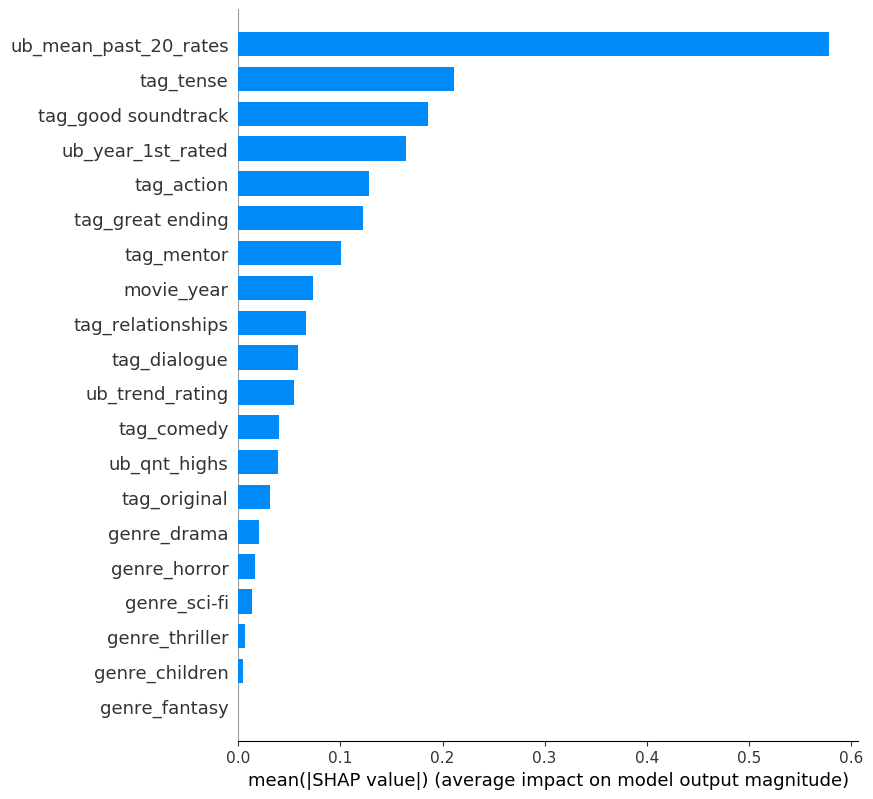

In [43]:
# Graficamos solo la importancia de cada variable
shap.summary_plot(shap_values, X_val_prep, plot_type="bar")

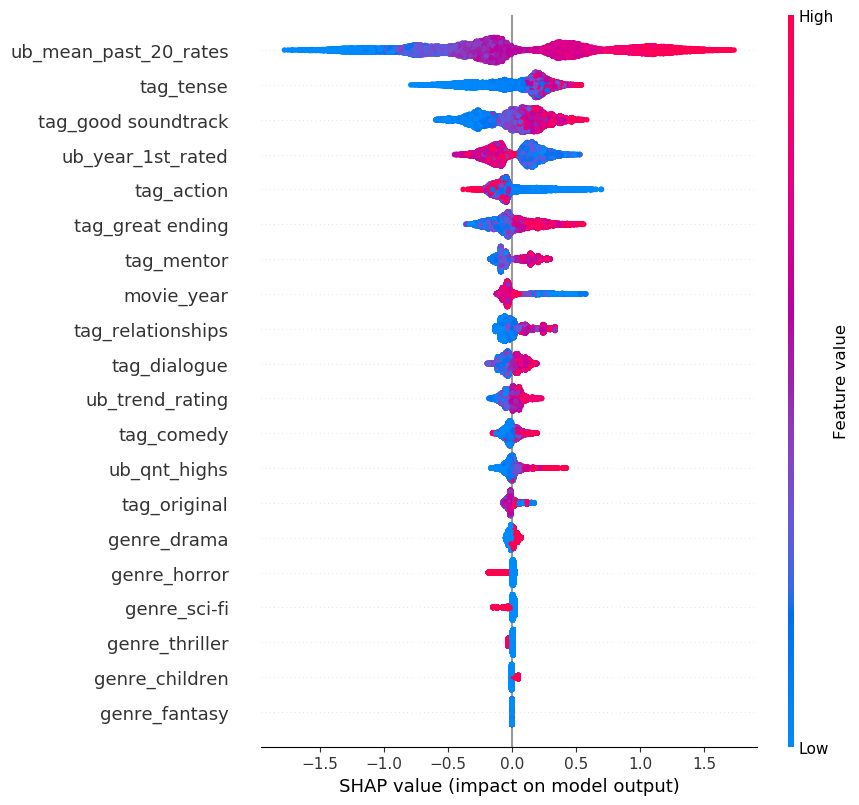

In [44]:
# Graficamos 
shap.summary_plot(shap_values, X_val_prep)

# Final Classification (optimizing F1 Score)

Text(0, 0.5, 'Recall')

Text(0.5, 0, 'Precision')

Text(0.5, 1.0, 'Precision Recall Curve')

Text(0, 0.5, 'F1 Score')

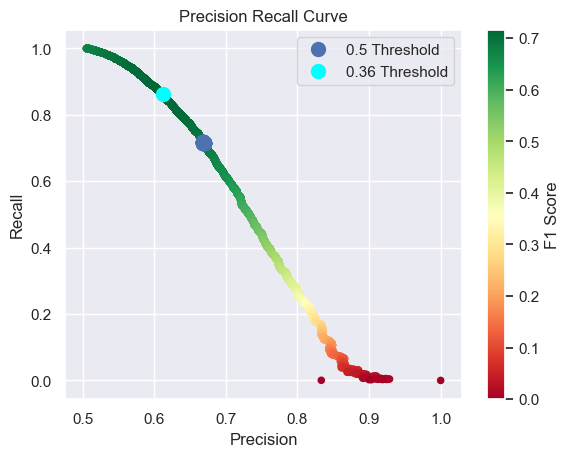

In [46]:
plt.style.use('default')
probs = y_val_pred
precision, recall, thresholds = precision_recall_curve(y_val, y_val_pred)
sns.set_theme()
current_thld = np.argwhere((thresholds >0.499) & (thresholds < 0.501))
f_scores = (2* precision * recall) / (precision + recall)
max_f = np.argmax(f_scores)
plt.scatter(precision, recall, c=f_scores, cmap='RdYlGn', s=20)
plt.plot(precision[current_thld], recall[current_thld], 'ob', label="0.5 Threshold", markersize=10)
plt.plot(precision[max_f], recall[max_f], "o", c='aqua',label="{:.2f} Threshold".format(thresholds[np.argmax(f_scores)]), markersize=10)
plt.ylabel('Recall')
plt.xlabel('Precision')
plt.title("Precision Recall Curve")
cbr = plt.colorbar()
cbr.ax.set_ylabel("F1 Score")
plt.legend()
plt.show()
plt.style.use('default')

In [47]:
max_threshold = thresholds[max_f]
print("Threshold that maximizes F1 score: {:.5f}".format(max_threshold))

Threshold that maximizes F1 score: 0.35647


Text(0.5, 1.0, 'Confusion matrix')

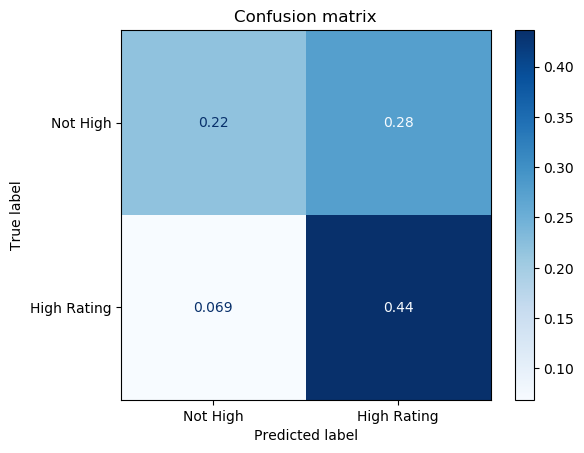

In [48]:
test_probs = y_val_pred 
test_preds = (test_probs > max_threshold).astype(int)
cm = confusion_matrix(y_val, test_preds, normalize="all")
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not High","High Rating"])
disp.plot(include_values=True, cmap=plt.cm.Blues, xticks_rotation="horizontal", colorbar=True)
disp.ax_.set_title("Confusion matrix")
plt.show()

### Output - Dataframe with predictions (includes Training, Test, and Out of time) --> it's the input dataset

In [49]:
X_final = df.drop(columns=['timestamp','date','target'])
X_final_prep = pipe_fitted.transform(X_final)
y_final = df[['target']]

In [50]:
predictions = pd.DataFrame(model.predict_proba(X_final_prep))[1]

In [51]:
df['predictions'] = np.array(predictions>max_threshold, dtype='int')

## Export Output, Model and Pipeline

In [56]:
df.to_csv('outputs/df_with_predictions.csv')

In [55]:
# Export model
joblib.dump(model, 'model/model.joblib')
# Export pipeline
joblib.dump(pipe, 'model/pipe.joblib')
joblib.dump(pipe_fitted, 'model/pipe_fitted.joblib')

['model/model.joblib']

['model/pipe.joblib']

['model/pipe_fitted.joblib']

# Business and Model Insights --> spoken

In [54]:
# Calculate total time of execution
end_time = time.time()
print(f"El script tarda {(end_time - start_time)/60} minutos en correr")

El script tarda 7.999396197001139 minutos en correr
